# Demo change point detection

There are quite a few algorithms that you can use to determine the change point. Have a look at the PELT (Pruned Exact Linear Time) algorithm, Binary Segmentation, or Bayesian changepoint detection methods. Have a look at [Truong et al., 2020](https://arxiv.org/pdf/1801.00718.pdf) for in depth knowledge.

There are also some Python-packages available that take away the burden of creating this functionality yourself. The most used is [the `ruptures` package](https://pypi.org/project/ruptures/) (from that same Truong et al.), but you can also use [the `changefinder` package](https://pypi.org/project/changefinder/). Look at [this interesting blog by Tech Rando](https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/) for more information.

In this demo-notebook we are going to start with the implementation of one of the algorithms that are described in [Cabrieto et al, 2015](https://link.springer.com/article/10.3758/s13428-016-0754-9). First, we will implement by hand the [PELT-algorithm](https://www.sciencepublishinggroup.com/article/10.11648/j.ajtas.20150406.30), which we wil then demonstrate using the already mentioned [ruptures](https://pypi.org/project/ruptures/) package. After that, we will implement a simplified version of [the DeCon-algoritm](), using a sliding window over our dataset to identify outliers. 

For a more thorough analyses of the relation between change point detection and ECG-data, please refer to [Moeyersons et al., 2019](https://www.sciencedirect.com/science/article/pii/S0169260719312817).

## 1. Pelt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
#plt.style.use('dark_background')

PELT (Pruned Exact Linear Time) is based on dynamic programming and optimal partitioning. It finds the most likely set of changepoints by minimizing a cost function over all possible segmentations of the data. Mathematically, it aims to minimize the total cost function:

$$
C(T) = \Sigma_{i=1}^{m+1}C(y_{t_{i-1}:t_i}) + \beta m
$$

Broadly speaking, PELT works in the following manner:

1. Define a cost function (here we will use SSE, which is customary).
2. Iterate over the time series and evaluates different ways to segment the data.
3. Store the best segmentation so far.
4. If a changepoint at time $t_t$ is unlikely based on previous computations, it is discarded.
5. Return a list of detected changepoints where the properties of the time series significantly change.



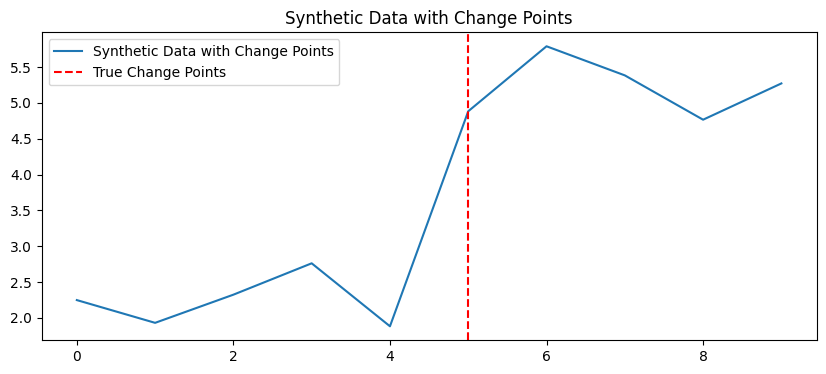

In [4]:
np.random.seed(42)
data = np.concatenate([
    np.random.normal(2, 0.5, 5),
    np.random.normal(5, 0.5, 5)
])

plt.figure(figsize=(10, 4))
plt.plot(data, label="Synthetic Data with Change Points")
plt.axvline(5, color="red", linestyle="--", label="True Change Points")
plt.legend()
plt.title("Synthetic Data with Change Points")
plt.show()


In [5]:
# Define the cost function: just use a standard SSE
def cost_func(segment):
    """Computes the cost (sum of squared differences from the mean) of a segment."""
    mean = np.mean(segment)
    return np.sum((segment - mean) ** 2)

# Example: Compute cost for first 20 points and first 50 points
#print("Cost for segment [0:20]:", cost_func(data[0:20]))
#print("Cost for segment [0:50]:", cost_func(data[0:50]))
cost_func([3,4,5])

2.0

In [14]:
data = np.array([3,4,5]) # this data was included for the presentation
data = np.array([3,4,5,11,12,13]) # for better example: data with actual changepoint
logging = False # set to True if you want to see the relevant output at each iteration

def log_var(var_str):
    if logging:
        print(var_str)

n = len(data)
F = np.full(n + 1, np.inf)  # Cost function values, initialized to infinity
cp = np.full(n + 1, -1)  # Store best change points
penalty = 5  # Regularization parameter

# Initial conditions
F[0] = 0
R = [0]  # Retained change points

# Dynamic programming with pruning
for t in range(1, n+1): 
    log_var(f'{t=}')
    costs = []
    candidates = []
    
    for s in R:
        log_var(f'*** {s=}')
        log_var(f'data: {data[s:t]}')
        segment_cost = cost_func(data[s:t])  # Cost of segment [s:t]
        log_var(f'{segment_cost=}')
        total_cost = F[s] + segment_cost + penalty
        log_var(f'{total_cost=}')
        costs.append(total_cost)
        candidates.append(s)
        
    log_var(f'{costs=}')
    log_var(f'{candidates=}')
        
    # Update F[t] with the minimum cost found
    min_cost_idx = np.argmin(costs)
    F[t] = costs[min_cost_idx]
    cp[t] = candidates[min_cost_idx]  # Store best previous changepoint
    log_var(f'{cp=}')
    log_var(f'{F=}')

    # Prune: Keep only promising candidates
    #R = [s for s in R if F[s] + cost_func(data[s:t]) + penalty <= F[t]]
    R.append(t)  # Always retain the current t
    log_var(f'{R=}')
    log_var('')

# Reconstruct change points by tracing back
t = n - 1
change_points = []
while t > 0:
    t = cp[t]
    if t > 0:
        change_points.append(t)

change_points.reverse()  # Make sure they are in order

print("Final computed cost function:", F[-1])
print("Detected change points:", change_points)


Final computed cost function: 14.0
Detected change points: [3]


Now we use the `Pelt`-class to abstract away all that math.

Detected changepoints: [50, 100, 150]


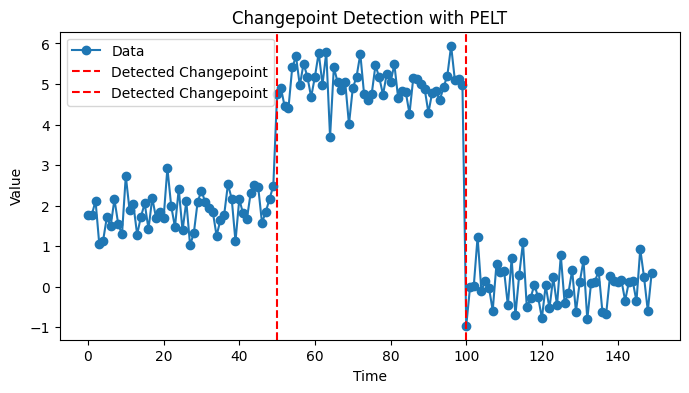

In [15]:
data = np.concatenate([
    np.random.normal(2, 0.5, 50),
    np.random.normal(5, 0.5, 50),
    np.random.normal(0, 0.5, 50)
])


algo = rpt.Pelt(model="rbf").fit(data)
changepoints = algo.predict(pen=5)  # Adjust 'pen' for sensitivity

# Print detected changepoints
print("Detected changepoints:", changepoints)

# Plot the data with detected changepoint
plt.figure(figsize=(8, 4))
plt.plot(data, label="Data", marker="o")
for cp in changepoints[:-1]:  # Ignore the last changepoint (end of data)
    plt.axvline(cp, color='r', linestyle="--", label="Detected Changepoint")
plt.legend()
plt.title("Changepoint Detection with PELT")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Let's create some noisy data and look how `ruptures` works with this (example [from the documentation itself](https://pypi.org/project/ruptures/).

In [16]:
# generate signal
n_samples, dim, sigma = 1_000, 3, 4
n_bkps = 6  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)


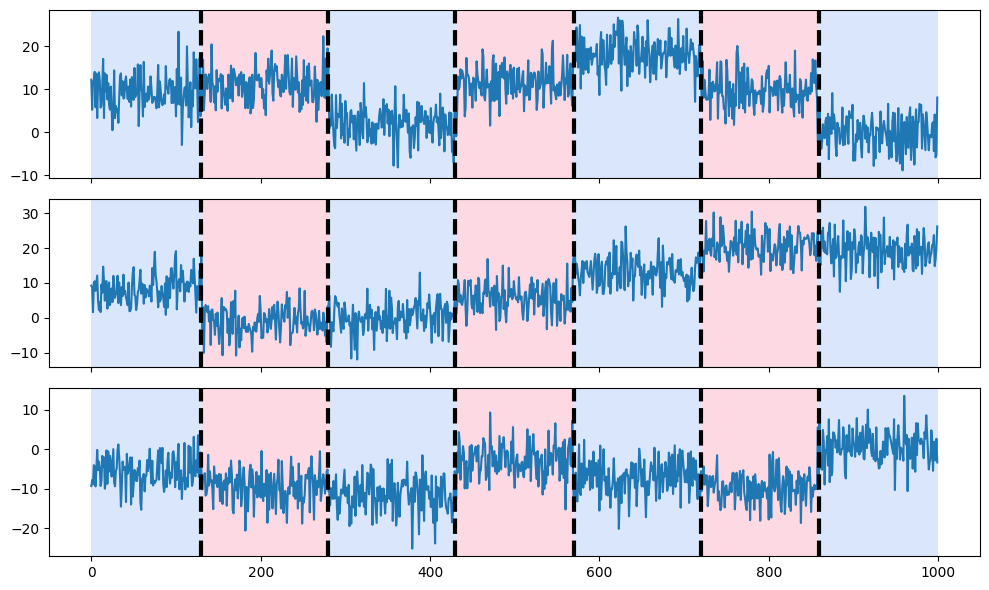

In [17]:
# display
rpt.display(signal, bkps, result)
plt.show()

## 2. DeCon

DeCon bases change point detection on outlier identification using robust statistics ([Bulteel et al., 2014](https://link.springer.com/article/10.3758/s13428-016-0754-9#ref-CR9)). The DeCon algorithm, short for Detection of Change in Signals using Deconvolution, is a method for detecting abrupt changes or change points in time series data. It is particularly useful when the data consists of a convolution of a smooth signal with an unknown kernel and noise.

The method slides a time window of size W across the time series by sequentially deleting the first time point in the window, and adding one new observation as the last time point. Per window, it is determined whether the last time point is an outlier with respect to the distribution of the other time points in the window. If the latter is the case for multiple consecutive windows, this signals that the observations that are added to the window might come from a different distribution, and, hence, that a change point occurred.

Specifically, DeCon consists of the following four steps.

1. Apply [Robust PCA](https://en.wikipedia.org/wiki/Robust_principal_component_analysis) in each time window and determine “outlyingness” of the last time point.
2. Track the moving sum of the outlyingness of ten subsequent last time points and declare a change point when this sum equals five at least.
3. Repeat steps 1 and 2 in the backward direction.
4. Combine change points detected in the forward and the backward procedure.


The following demonstration is just a start point for this algorithm. If you want to implement it completely, you could use [the sklearn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for the PCA. Or check [this implementation of Robus PCA](https://github.com/dganguli/robust-pca); have a look at [this discussion at StackOverflow](https://stackoverflow.com/a/42451260).

In this example we use the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) to determine the distance of point `x_last` from a distribution defined by `mu_w` and `cov_w`:

$$ MD(x) = \sqrt{ (x-\mu)^T \Sigma^{-1}(x-\mu)} $$

In [18]:
mu1 = [1, 2, 3]
cov1 = [ [1,0,0], [0,1,0], [0,0,1] ]
mu2 = [3, 6, 9]
cov2 = [ [1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1] ]
data1 = np.random.multivariate_normal(mu1, cov1, size=(25,))
data2 = np.random.multivariate_normal(mu2, cov2, size=(25,))
data = np.append(data1, data2, axis=0)

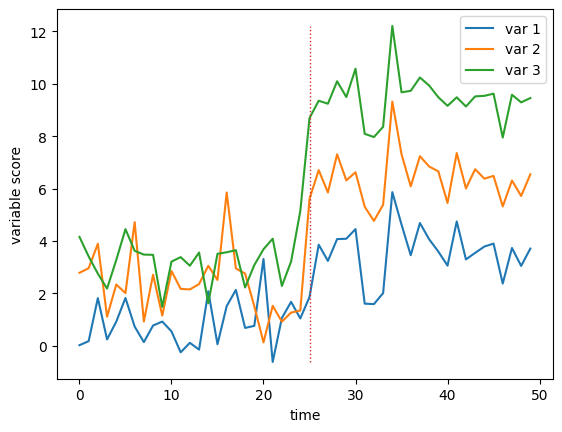

In [19]:
fig = plt.plot(data)
plt.rcParams['figure.figsize'] = (30,10)
plt.plot([25, 25], [np.min(data), np.max(data)], linestyle=':', linewidth=1) # changepoint is here
plt.xlabel('time')
plt.ylabel('variable score')
plt.legend(iter(fig), ('var 1','var 2','var 3'))

In [20]:
# Define the mahalanobis_distance
def mahalanobis_distance(x_last, mu_w, cov_w):
    return np.sqrt((x_last-mu_w).T.dot(np.linalg.inv(cov_w).dot(x_last - mu_w)))

# Check it with some known data
x_last = np.array( [1.08, 4.37, 7.36] )
u_w = np.array( [1.41, 1.89, 3.18] )
cov_w = np.array( ([0.29, -0.15, 0.11], [-0.15, 0.62, 0.13], [0.11, 0.13, 0.57]) )

# Should be around 6.06
mahalanobis_distance(x_last, u_w, cov_w)

6.062852612897912

In our example, we use a *window size* of twenty. Then we start at point 0 (so we have `data[:, 0:20]`) and continue until all data has been consumed.

In [21]:
w_size = 20 
i = 0
sd = [] # list to store the calculated score distances
while i+w_size < len(data):
    cov = np.cov(data.T[:, i:i+w_size])
    mu = np.mean(data.T[:, i:i+w_size], axis=1)
    dist = mahalanobis_distance(data[i+w_size-1], mu, cov)
    sd.append(dist)
    i += 1

Now we scatter the found score distances, adding the *window size* at the x-axis to make clear which was the index of the last time-point of our window.

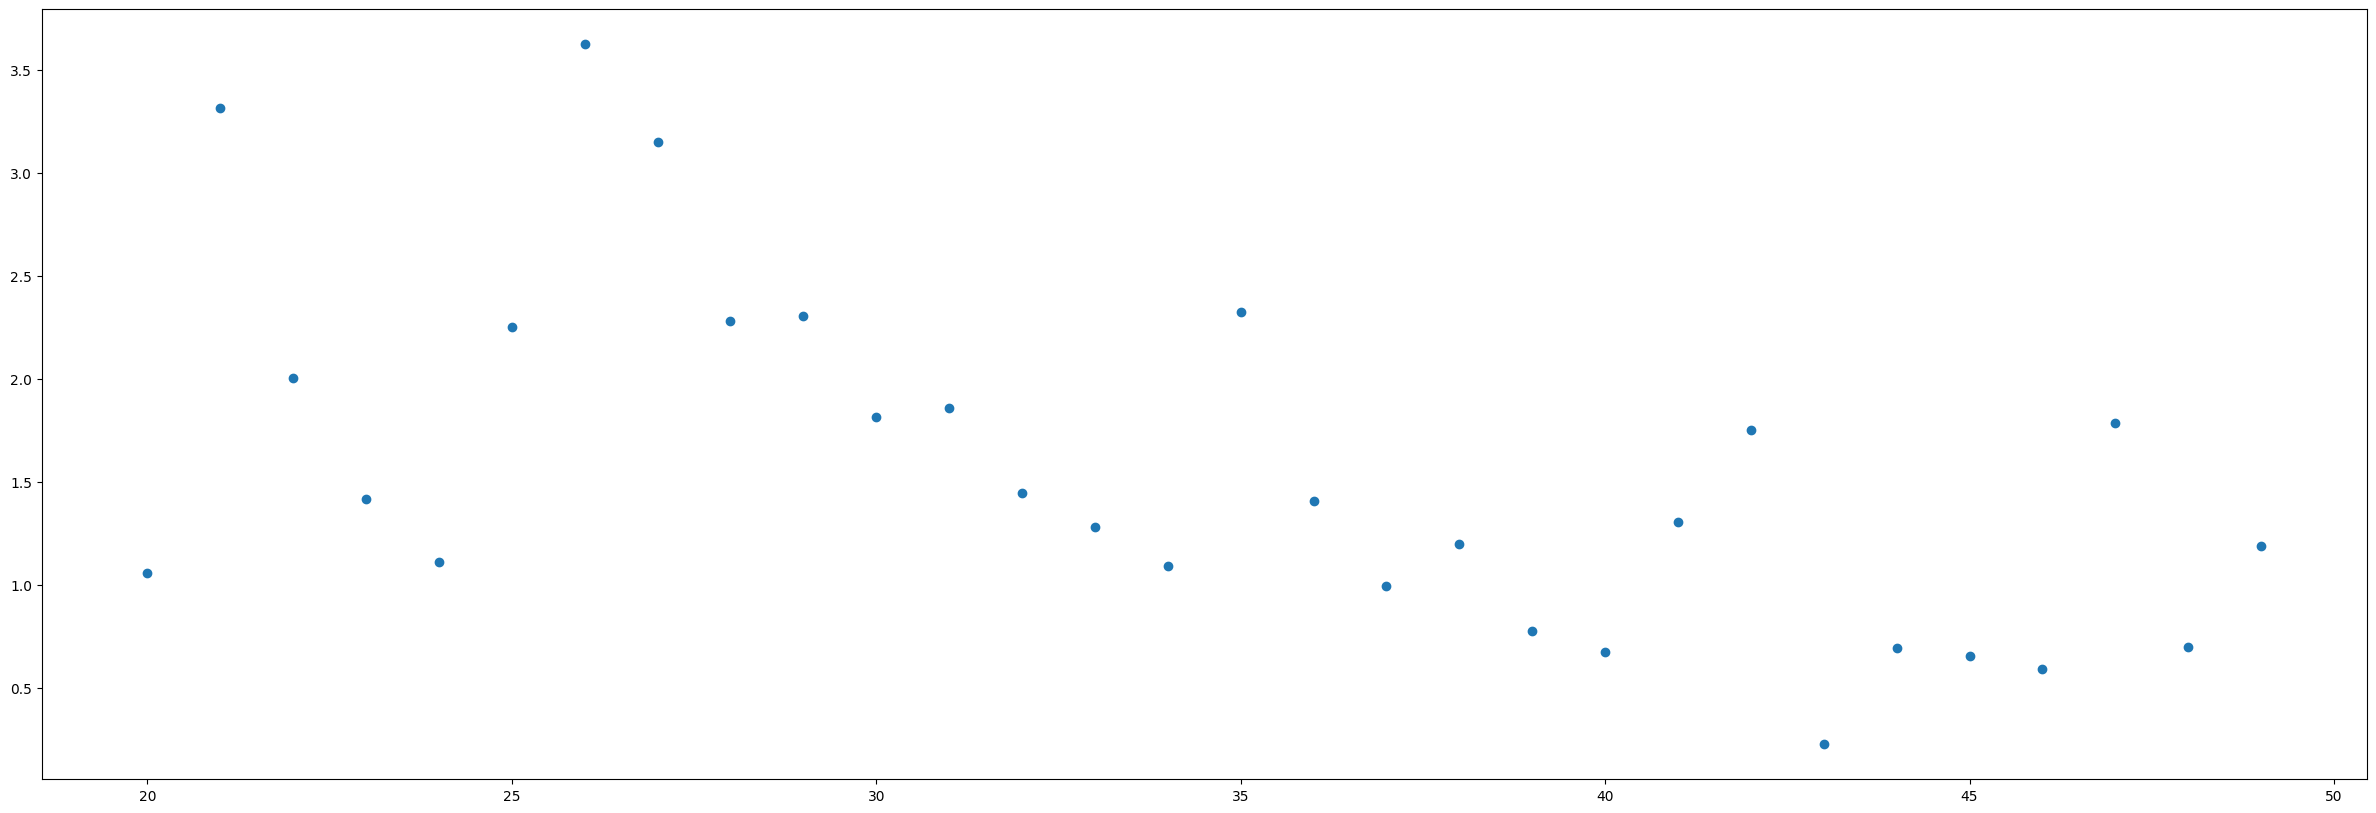

In [22]:
plt.scatter(np.arange(len(sd))+w_size, sd)

Now we need to determine which points within our set (the list `sd`) are actually outliers. In the following implementation we are using the IQR.

In [25]:
def outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    return [i for i, x in enumerate(data) if x < lower_bound or x > upper_bound]

print (outliers(sd))

[6]


So we can conclude that the sixth element of our `sd` list is an outlier. That means that our change point is located at `6+window_size = 26`, which seems to be correct.